# Directed Erdos-Renyi link community walkthrough
Authored by Jorge S. Martinez Armas.

This notebook demonstrates how to run the LinkNodeCommunity algorithm on a synthetic directed Erdos-Renyi graph. The aim is to illustrate how the hierarchy of link communities is built and how the density (D) and loop entropy (S) statistics behave. These statistics are introduced in Martinez-Armas et al. (2024), and S is computed by the `S` function in `cpp/link_hierarchy_statistics_cpp/src/main.cpp`.

We proceed step by step:
1. import the required Python wrappers,
2. generate a random graph and fit the hierarchical model, and
3. read the hierarchy through plots and partitions selected by maximizing D or S.

Short explanations accompany each code block so that a reader new to the algorithm can reproduce the workflow without digging into the implementation details.


In [1]:
# Standard Python libs ----
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
import sys

# Add the parent directory to sys.path so src can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import LinkNodeCommunity as linknode
from src.LinkNodeCommunity.utils import linknode_equivalence_partition
from src.viz.graphics import link_statistics_graph, linkcommunity_matrix_map, dendrogram

## Step 1 · Generate a directed Erdos-Renyi graph
We draw a G(N, M) random graph with fixed density `rho`. For a directed network the maximum number of possible edges is `N * (N - 1)`, so we sample `M = rho * N * (N - 1)` edges uniformly at random. The random seed keeps the example reproducible.

Key parameters:
- `rho`: density of the directed network.
- `N`: number of nodes.
- `M`: number of sampled directed edges.
- `seed`: random generator seed.

After the graph is created we label the nodes and instantiate the LinkNodeCommunity clustering model.


In [2]:
rho = 0.6                                                   # Network density
N = 50                                                      # Number of nodes
M = int(N * (N - 1) * rho)                                  # Number of edges
seed = 12321                                                # Random seed
G = nx.gnm_random_graph(N, M, seed=seed, directed=True)     # Create random graph using networkx


assert not any(G.has_edge(n, n) for n in G.nodes), "Graph G contains self-loops."

labels = np.arange(N).astype(int).astype(str)               # Create the nodes' labels

labels_dict = dict()
for i in np.arange(N):
  labels_dict[i] = labels[i]

## Step 2 · Fit the link hierarchy model
The clustering model builds a hierarchy over the edges by comparing link similarity scores. The call to `process_features_edgelist` records the link statistics at every merge. Internally, the loop entropy `S` is obtained via the C++ routine mentioned above, which computes the information content of excess edges relative to a spanning-tree baseline.

The object `link_hierarchy_statistic` now stores, for each level `K`, the values of D (average community density), S (loop entropy), and other bookkeeping quantities.


In [3]:
# LinkNodeCommunity model fitting
model = linknode.Clustering(G, similarity_index="cosine_similarity", consider_subgraph=False)
model.add_labels(labels_dict)
model.fit(use_parallel=True, method="edgelist", max_dist=1.0)

## Step 3 · Inspect hierarchy-level statistics
The two panels show how the number of link communities `K` relates to our scores. The density score `D` (left) measures how many excess links each community carries relative to its size. The loop entropy `S` (right) is the sum `-\sum_c p_c log p_c`, where `p_c = (m_c - n_c + 1)/(M - N + 1)` is computed by the `S` function in the C++ backend. The remaining probability mass corresponds to the tree remainder described in the manuscript. Use these curves to anticipate which levels will be highlighted when maximizing each score.


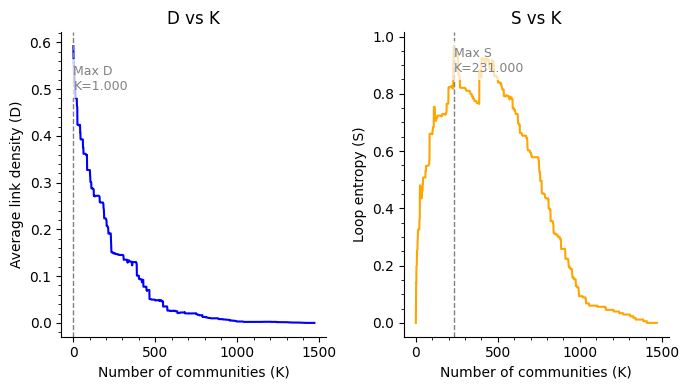

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
link_statistics_graph(
    link_stats=model.link_stats,
    x="K",
    y="D",
    xlabel="Number of communities (K)",
    ylabel="Average link density (D)",
    color="blue",
    ax=axes[0]
)

link_statistics_graph(
    link_stats=model.link_stats,
    x="K",
    y="S",
    xlabel="Number of communities (K)",
    ylabel="Loop entropy (S)",
    color="orange",
    ax=axes[1]
)
fig.tight_layout()
plt.show()

## Step 4 · Compare the partitions picked by each score
`linknode_equivalence_partition` scans the hierarchy and returns the level that maximizes the requested statistic. The heatmaps below display the link membership matrix at those levels: rows and columns correspond to links, colours encode community assignment, and the black grid lines mark community boundaries.


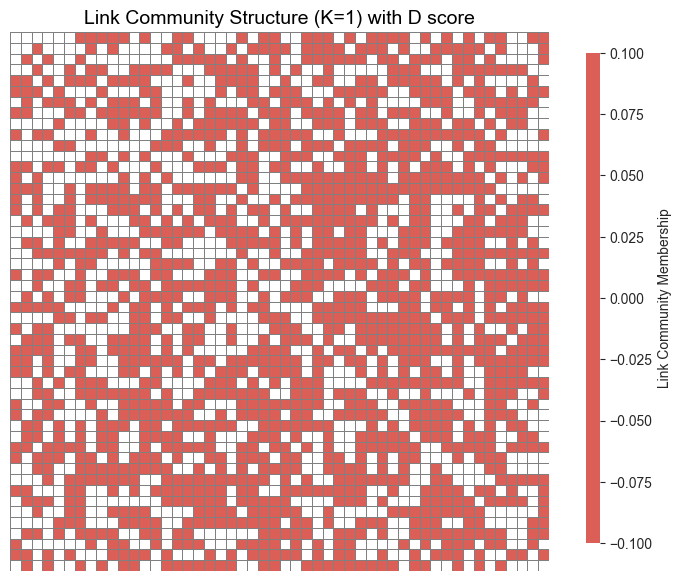

In [5]:
# Link-node equivalence partitioning (D score)
# Returns (link communities, node communities, merge height)
number_link_communities, \
    number_node_communities, \
        height_at_maximum = linknode_equivalence_partition(
            score="D",
            link_stats=model.link_stats,
            linknode_equivalence=model.linknode_equivalence)

# Visualize link community structure as a matrix
# Black grid lines mark community boundaries
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
linkcommunity_matrix_map(
    G,
    model.get_hierarchy_edgelist(1.0),
    model.Z,
    number_link_communities,
    number_node_communities,
    labels=labels[:model.N],
    linewidth=1.75,
    palette="hls",
    remove_labels=True,
    cbar_position=[0.95, 0.15, 0.02, 0.7],
    ax=ax
)
_ = ax.set_title(f"Link Community Structure (K={number_link_communities}) with D score", fontsize=14)

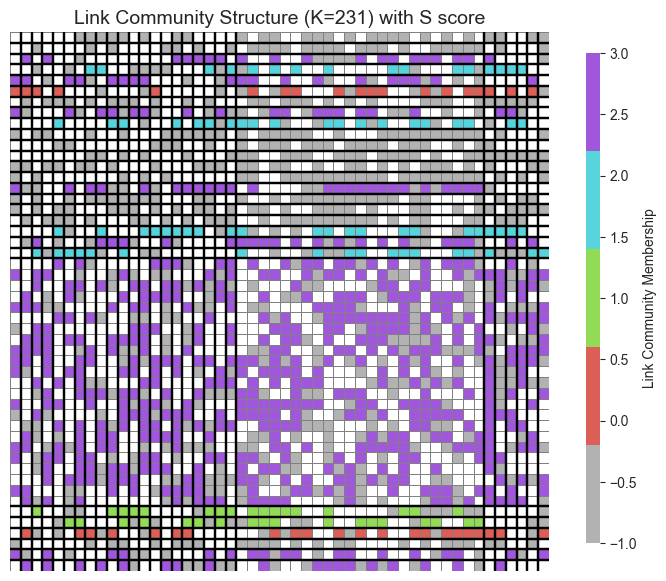

In [6]:
# Link-node equivalence partitioning (S score)
# Returns (link communities, node communities, merge height)
number_link_communities, \
    number_node_communities, \
        height_at_maximum = linknode_equivalence_partition(
            score="S",
            link_stats=model.link_stats,
            linknode_equivalence=model.linknode_equivalence)

# Visualize link community structure as a matrix
# Black grid lines mark community boundaries
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
linkcommunity_matrix_map(
    G,
    model.get_hierarchy_edgelist(1.0),
    model.Z,
    number_link_communities,
    number_node_communities,
    labels=labels[:model.N],
    linewidth=1.75,
    palette="hls",
    remove_labels=True,
    cbar_position=[0.95, 0.15, 0.02, 0.7],
    ax=ax
)
_ = ax.set_title(f"Link Community Structure (K={number_link_communities}) with S score", fontsize=14)

## Step 5 · Visualize the level at the maximum S level
The dendrogram focuses on the node partition induced by the S optimum. It helps verify whether the selected cut corresponds to a meaningful branching structure or simply balances one dominant community against the tree remainder.


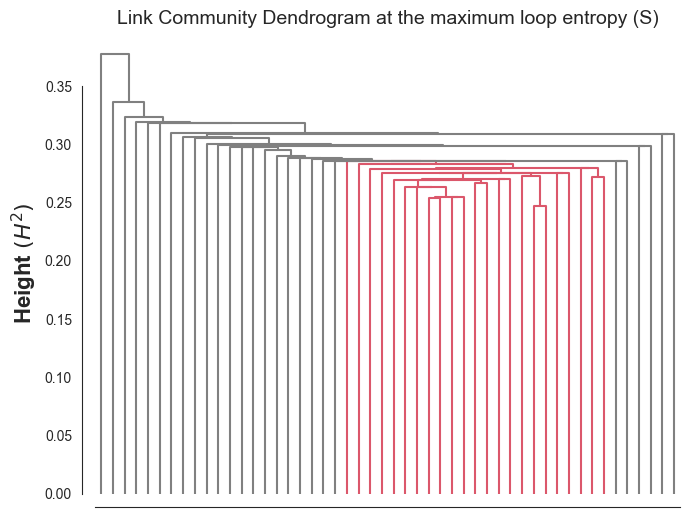

In [7]:
# Dendrogram at the Goldilocks level (S score)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

dendrogram(
    model.Z,
    number_node_communities,
    ylabel="Height " + r"$(H^{2})$",
    remove_labels=True,
    ax=ax
)

fig.tight_layout()
_ = ax.set_title("Link Community Dendrogram at the maximum loop entropy (S)", fontsize=14)

## Observations
In a dense directed Erdos-Renyi network the algorithm mainly finds a single dominant community plus noise. Maximizing the density score `D` collapses the hierarchy to the trivial partition (`K = 1`), because aggregating all links maximizes the average link density. The link membership matrix for the D optimum therefore shows a single block.

Maximizing the loop entropy `S` leads to a different reading. The `S` function (see `cpp/link_hierarchy_statistics_cpp/src/main.cpp`) measures the Shannon entropy of the probability distribution over excess edges: each community contributes `p_c = (m_c - n_c + 1)/(M - N + 1)` and the remainder `(1 - \sum_c p_c)` is assigned to the tree set. `S` is largest when those probabilities are close to uniform. In this example the S optimum balances one large community and the tree remainder, which makes their probabilities comparable and thus increases entropy.

This outcome illustrates a key point from Martinez-Armas et al. (2024): a high `S` value does not imply a richly structured community layout. Instead it certifies that the excess edges are evenly spread between the main community and the unstructured tree remainder. When interpreting the `S` optimum one should therefore check whether the highlighted level reveals meaningful meso-scale organization or simply reflects the absence of structure.
